In [91]:
import numpy as np
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

In [92]:
file_dir = os.getcwd()
data_dir = os.path.join(file_dir, 'datasets')

In [93]:
cds_csv_path = os.path.join(data_dir, 'cds.csv')
cds_data = pd.read_csv(cds_csv_path, index_col='Date')

In [94]:
cds_data.head()

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


In [95]:
def autocorrelation_plotter(dataset, ticker, lagmin=1, lagmax=50, squared=False):

    tickerset = dataset[dataset['Ticker'] == ticker]
    px_columns = [f'PX{i}' for i in range(1, 11)]

    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))
    axes = axes.flatten()

    # iterate over PX columns and plot ACF for each
    for i, col in enumerate(px_columns):
        price_col = tickerset[col]

        if squared == True:
            plot_acf(price_col**2, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')
        else:
            plot_acf(price_col, lags=np.arange(lagmin, lagmax), ax=axes[i], title=f"Autocorr: {col}", auto_ylims=True, color='firebrick')
        
        axes[i].set_xlim(lagmin, lagmax)
        axes[i].set_xlabel("Lags")
        axes[i].set_ylabel("Autocorrelation")
    
    plt.tight_layout()
    plt.suptitle(f"Autocorrelation of CDS Prices for Ticker: {ticker}", fontsize=14, y=1.02)
    plt.show()

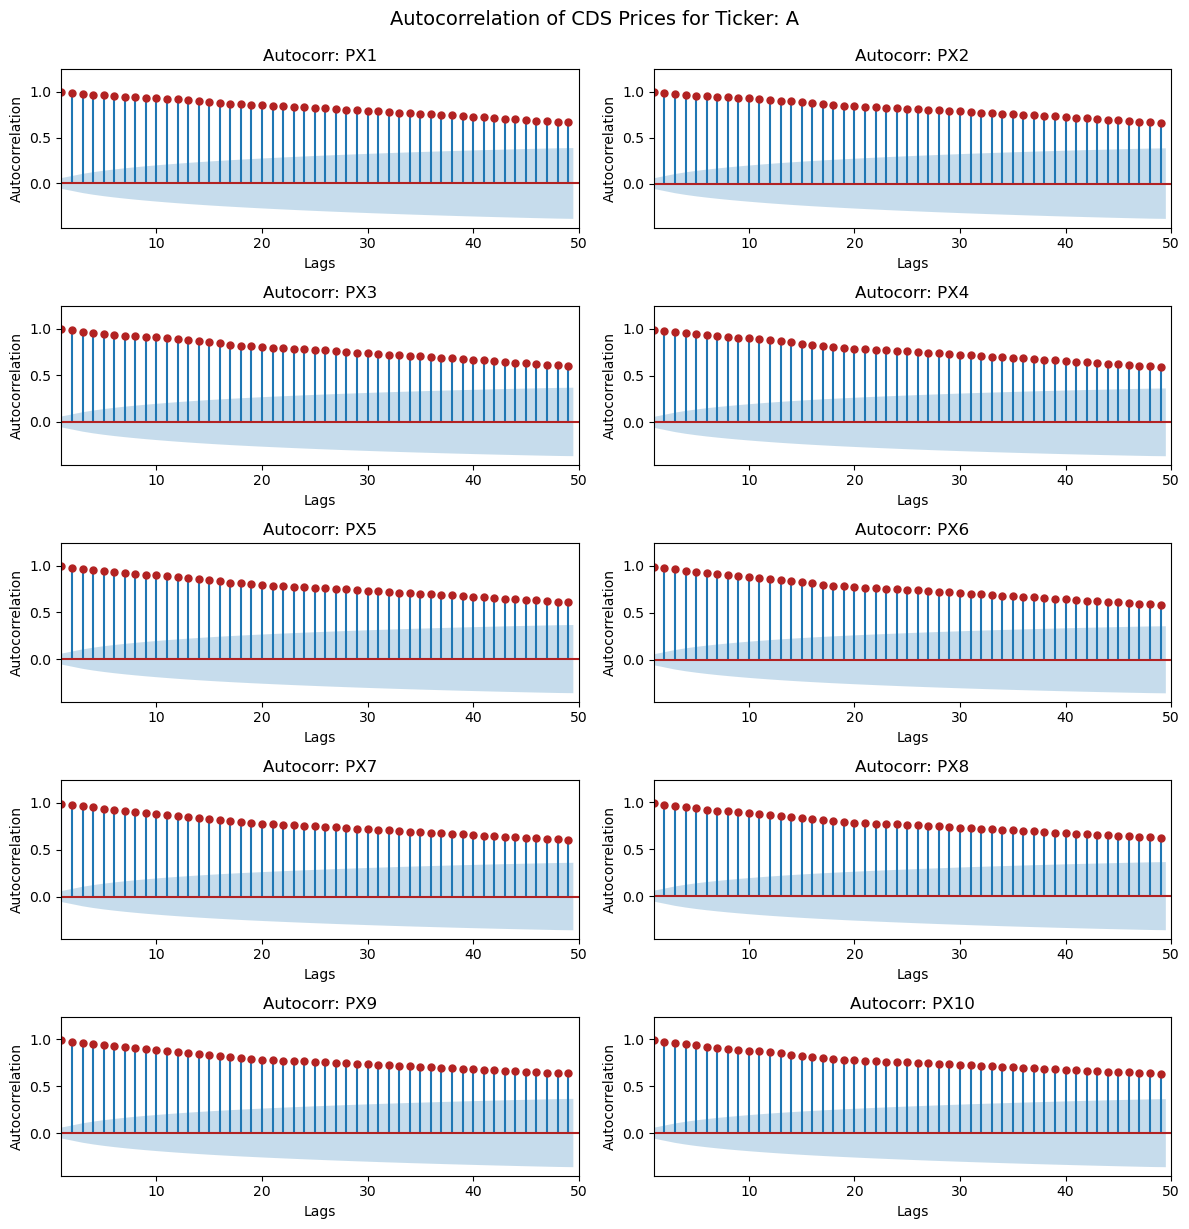

In [96]:
autocorrelation_plotter(cds_data, 'A')

In [97]:
def calculate_log_returns(dataset):
    
    px_columns = [f'PX{i}' for i in range(1, 11)]
    returns_df = dataset.copy()
    
    # group by ticker and apply log returns transformation
    for col in px_columns:
        returns_df[col] = dataset.groupby('Ticker')[col].transform(lambda price: (np.log(price/100) - np.log((price/100).shift(1)))*100)
    
    return returns_df

In [98]:
def calculate_first_diffs(dataset):
    
    px_columns = [f'PX{i}' for i in range(1, 11)]
    returns_df = dataset.copy()
    
    # group by ticker and apply log returns transformation
    for col in px_columns:
        # divide by 100 because spreads are in basis points (% * 100)
        returns_df[col] = dataset.groupby('Ticker')[col].transform(lambda price: price/100 - price.shift(1)/100)
    
    return returns_df

In [99]:
cds_returns = calculate_log_returns(cds_data)
cds_returns = cds_returns.dropna()

cds_returns.head()

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-02,A,Agilent Technologies Inc,0.033664,0.398407,0.268491,-0.156128,0.115808,0.184009,0.154759,0.051962,0.110280,0.106961
2015-01-05,A,Agilent Technologies Inc,-9.898572,-0.758335,0.382312,-4.729671,2.129933,0.411671,-0.828162,-0.841627,-0.879307,-0.924828
2015-01-06,A,Agilent Technologies Inc,14.374476,-0.321028,-0.025442,3.471793,3.167080,4.060406,4.556365,4.906786,5.121228,5.288501
2015-01-07,A,Agilent Technologies Inc,-2.081376,2.461418,2.438226,1.637591,1.525084,0.998344,0.799000,0.517397,0.337482,0.232836
2015-01-08,A,Agilent Technologies Inc,-3.002227,2.325686,0.865378,-0.325380,0.625069,-0.989769,-1.889808,-1.762101,-1.729517,-1.727880


In [100]:
cds_diffs = calculate_first_diffs(cds_data)
cds_diffs = cds_diffs.dropna()

cds_diffs.head()

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-01-02,A,Agilent Technologies Inc,0.00005,0.0010,0.00105,-0.00115,0.0010,0.00205,0.00195,0.00075,0.00175,0.0018
2015-01-05,A,Agilent Technologies Inc,-0.01400,-0.0019,0.00150,-0.03400,0.0186,0.00460,-0.01040,-0.01210,-0.01390,-0.0155
2015-01-06,A,Agilent Technologies Inc,0.02080,-0.0008,-0.00010,0.02480,0.0284,0.04640,0.05830,0.07200,0.08270,0.0906
2015-01-07,A,Agilent Technologies Inc,-0.00320,0.0062,0.00970,0.01200,0.0140,0.01170,0.01050,0.00780,0.00560,0.0041
2015-01-08,A,Agilent Technologies Inc,-0.00450,0.0060,0.00350,-0.00240,0.0058,-0.01160,-0.02470,-0.02640,-0.02850,-0.0302


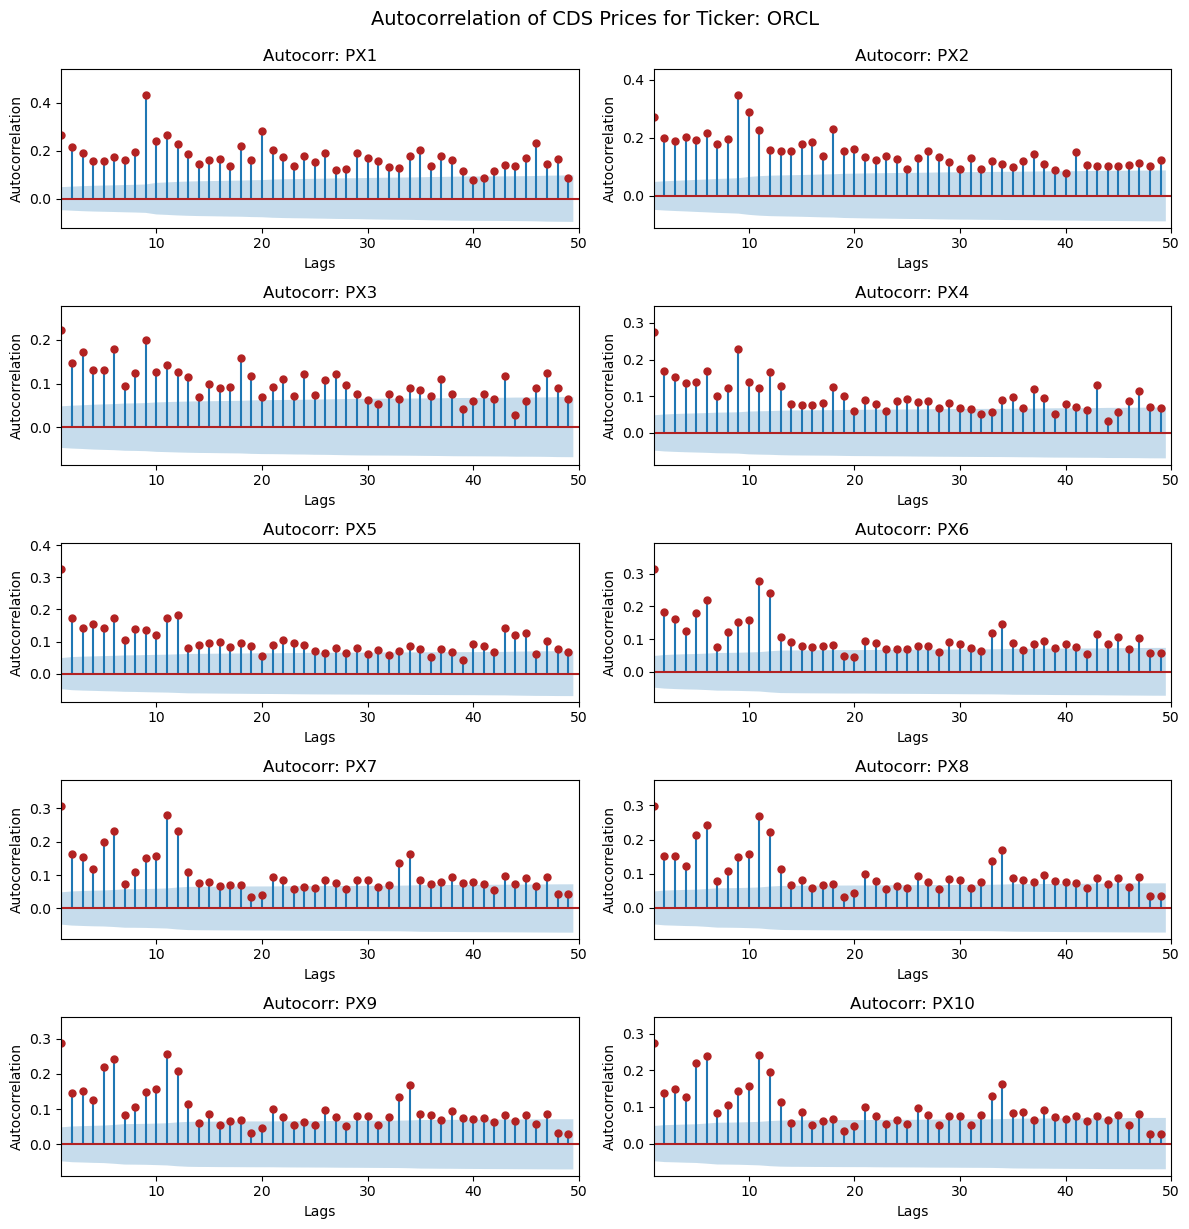

In [101]:
autocorrelation_plotter(cds_returns, 'ORCL', squared=True)

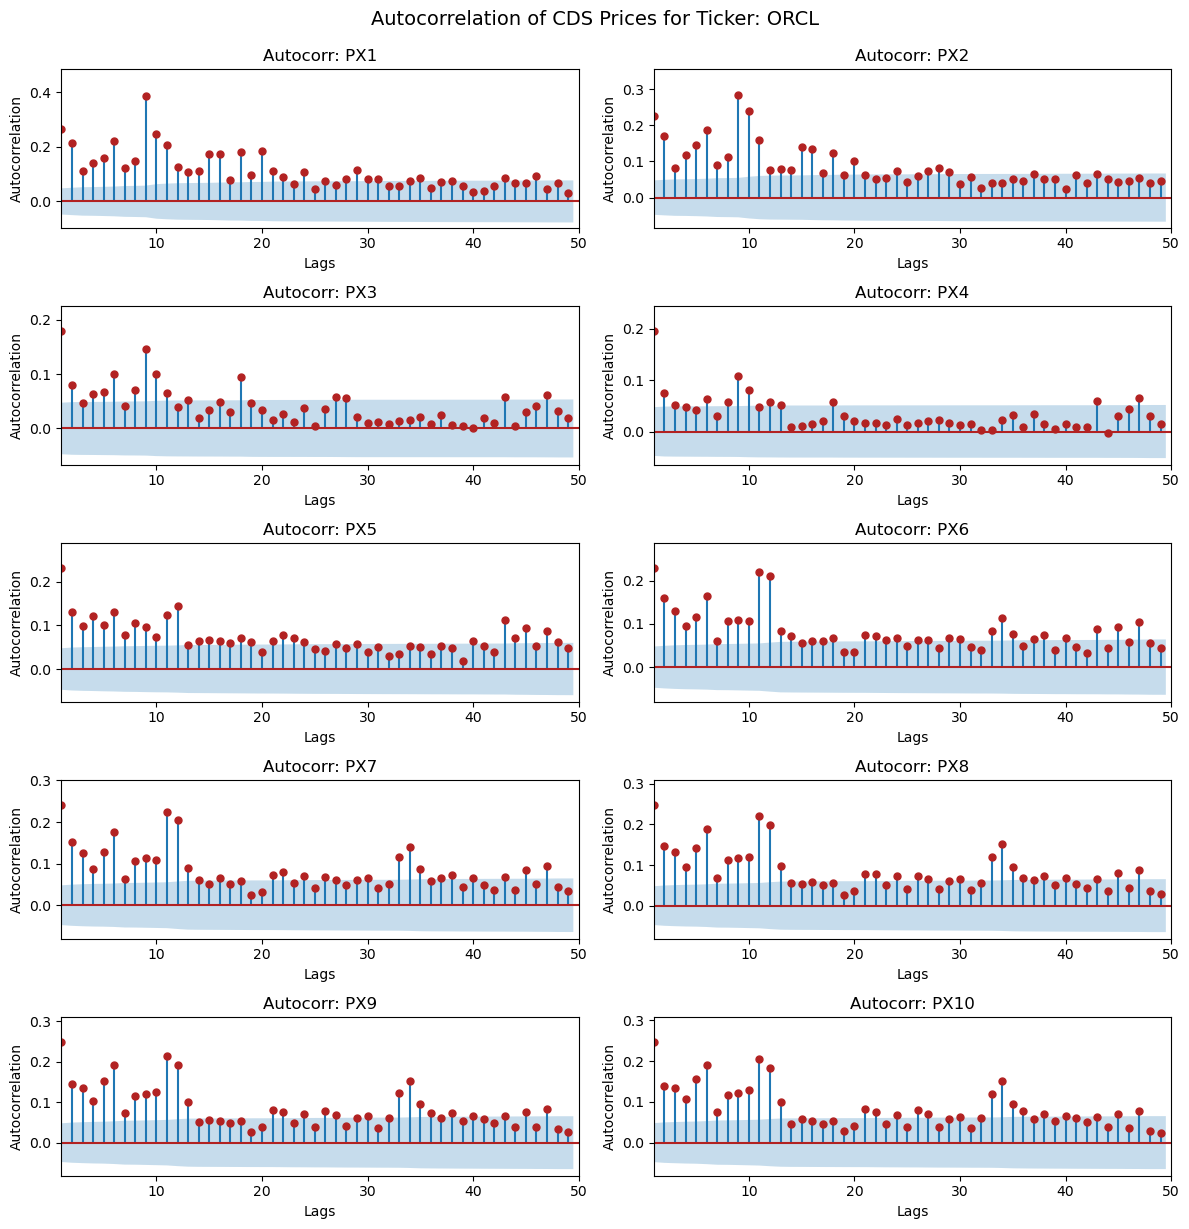

In [102]:
autocorrelation_plotter(cds_diffs, 'ORCL', squared=True)

We can see that a GARCH model is appropriate here

Imported Parallel and delayed otherwise this code would take excessively long to run (days)

In [109]:
from joblib import Parallel, delayed

def fit_garch(data, p, q):

    model = arch_model(data, p=p, q=q, mean='Zero', rescale=True).fit(disp='off')

    return p, q, model.aic

In [110]:
def AIC_picker(dataset, max_p=3, max_q=3):
    
    px_columns = [f'PX{i}' for i in range(1, 11)]    
    tickers = dataset['Ticker'].unique()
    results = {}

    for col in px_columns:
        results[col] = {}

        for ticker in tickers:
            subset = dataset[dataset['Ticker'] == ticker][col].dropna()

            fit_results = Parallel(n_jobs=-1)(delayed(fit_garch)(subset, p, q) for p in range(1, max_p + 1) for q in range(1, max_q + 1))

            best_aic = fit_garch(subset, p=1, q=1)[-1]
            best_order = (1,1)

            for p, q, aic in fit_results:
                if aic > best_aic:
                    best_aic = aic
                    best_order = (p,q)

            results[col][ticker] = {'best_p': best_order[0], 'best_q': best_order[1], 'AIC': best_aic}
    
    return results

In [111]:
cds_returns[cds_returns['PX1'] == max(cds_returns['PX1'])]

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2018-11-15,PCG,Pacific Gas & Electric Co,301.882913,223.018479,181.266429,148.417296,124.465075,110.372985,100.800798,94.605202,89.835781,86.129659


In [112]:
cds_diffs[cds_diffs['PX1'] == max(cds_diffs['PX1'])]

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-07-07,ALPHA,Alpha Bank AE,126.24295,89.35555,63.70345,44.01595,28.05505,18.4975,12.1893,6.5454,1.675,-2.5856


In [113]:
aic_values_garch = AIC_picker(cds_diffs)

c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\user-pc\anaconda3\Lib\site-packages\arch\univariate\volatility.py:1197: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
c:\Users\user-pc\anaconda3\Lib\site-packa

In [ ]:
cds_returns[cds_returns['PX1'] == max(cds_returns['PX1'])]

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2018-11-15,PCG,Pacific Gas & Electric Co,301.882913,223.018479,181.266429,148.417296,124.465075,110.372985,100.800798,94.605202,89.835781,86.129659


In [ ]:
# cds_diffs[cds_diffs['PX1'] == max(cds_diffs['PX1'])]
# cds_data[cds_data['Ticker'] == 'ALPHA']['2015-07-05':'2015-07-16']

,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,,,
2015-07-07,ALPHA,Alpha Bank AE,12624.295,8935.555,6370.345,4401.595,2805.505,1849.75,1218.93,654.54,167.5,-258.56


In [114]:
aic_values_garch

{'PX1': {'A': {'best_p': 1, 'best_q': 1, 'AIC': 5524.838629333539},
  'AALLN': {'best_p': 1, 'best_q': 2, 'AIC': 679.1120218379178},
  'AAPL': {'best_p': 1, 'best_q': 1, 'AIC': 2175.001651446534},
  'ABBNVX': {'best_p': 1, 'best_q': 3, 'AIC': 262.7489571065921},
  'ABBV': {'best_p': 3, 'best_q': 1, 'AIC': 2898.2469633293167},
  'ABC': {'best_p': 1, 'best_q': 2, 'AIC': 3278.9107506400105},
  'ABESM': {'best_p': 1, 'best_q': 1, 'AIC': 5540.531806850676},
  'ABIBB': {'best_p': 3, 'best_q': 1, 'AIC': 4879.817710462407},
  'ABT': {'best_p': 3, 'best_q': 1, 'AIC': 2711.8659210729757},
  'ABXCN': {'best_p': 3, 'best_q': 1, 'AIC': 3757.80461070525},
  'ACAFP': {'best_p': 1, 'best_q': 3, 'AIC': 5660.183748341652},
  'ACEIM': {'best_p': 3, 'best_q': 1, 'AIC': 5360.193206711991},
  'ACFP': {'best_p': 3, 'best_q': 1, 'AIC': 4952.009107196975},
  'ADENVX': {'best_p': 3, 'best_q': 1, 'AIC': 3154.965803078827},
  'ADLERR': {'best_p': 3, 'best_q': 1, 'AIC': 1144.275984019674},
  'ADM': {'best_p': 1, '

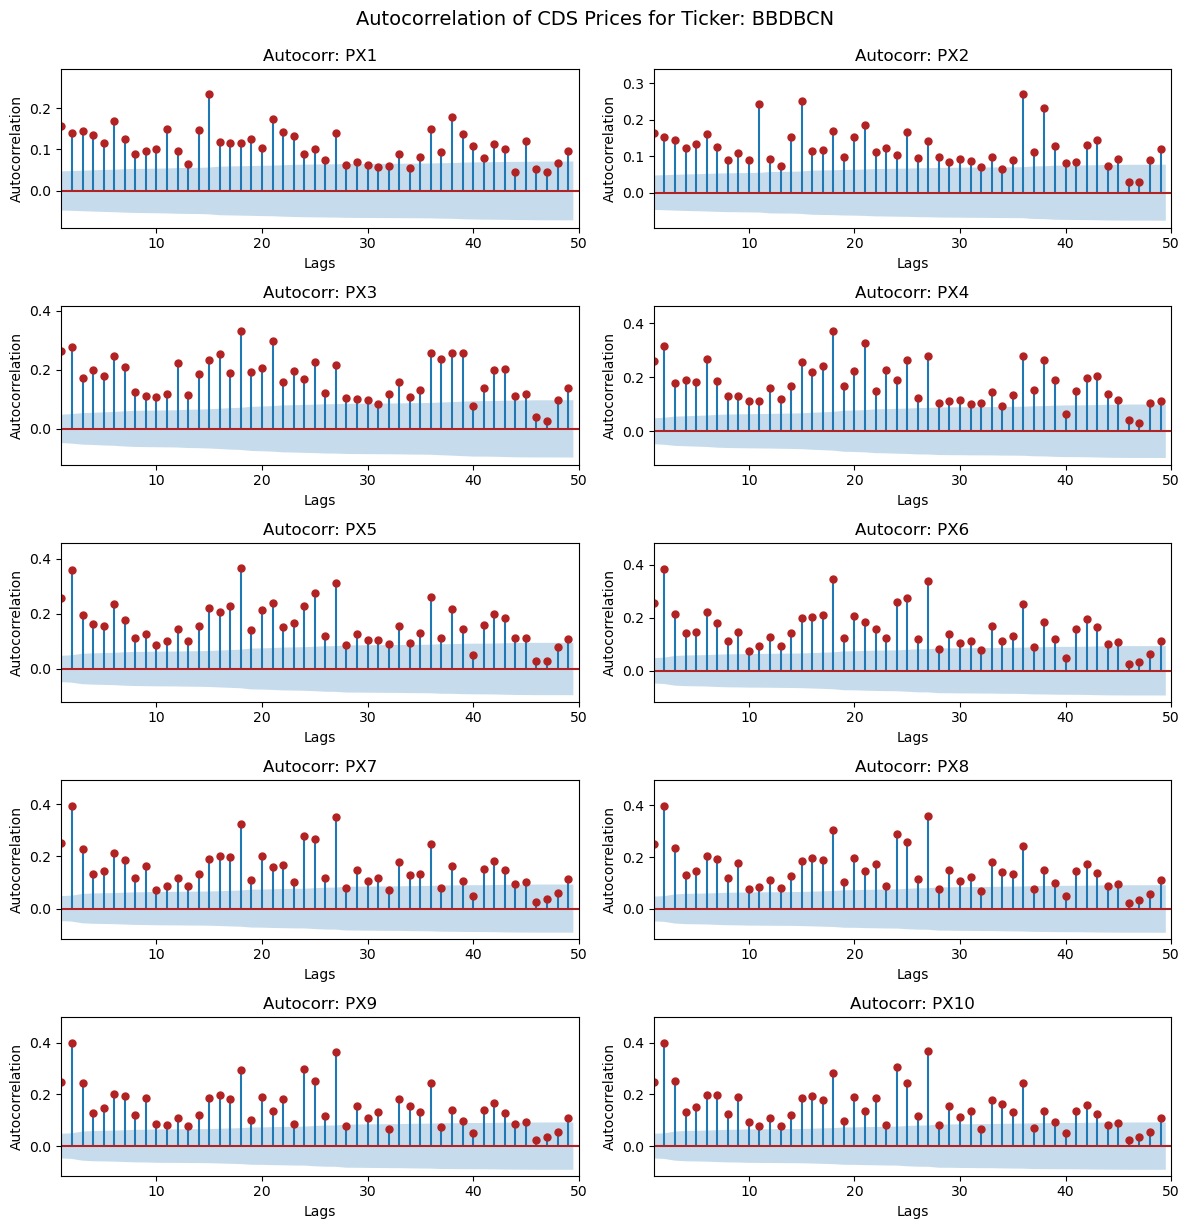

In [116]:
autocorrelation_plotter(cds_diffs, 'BBDBCN', squared=True) 

In [123]:
# def ten_day_price_forecast(dataset, model_results, K=10, MC=10000, dist='Normal', n_jobs=-1):

#     def simulate_cumulative_returns(subset, p_opt, q_opt, dist):

#         # fit GARCH
#         model = arch_model(subset, vol='Garch', p=p_opt, q=q_opt, mean='Zero', rescale=True)
#         result = model.fit(disp="off")
        
#         # 1-day ahead var forecast
#         forecast = result.forecast(horizon=1)
#         one_day_ahead_variance = forecast.variance.iloc[-1, 0]

#         # GARCH params
#         omega = result.params['omega']
#         alpha = result.params['alpha[1]']
#         beta = result.params['beta[1]']

#         # Monte Carlo simulation
#         sim_cumulative_returns = np.zeros((MC, K))
#         if dist == 'Normal':
#             sim_shocks = np.random.randn(K, MC)
#         else:
#             d1 = result.distribution.df
#             sim_shocks = np.sqrt((d1 - 2) / d1) * stats.t.rvs(d1, size=(K, MC))

#         cond_variance = np.zeros((K, MC))
#         cond_variance[0, :] = one_day_ahead_variance
        
#         for k in range(1, K):
#             cond_variance[k, :] = omega + alpha * (sim_shocks[k-1, :] ** 2) + beta * cond_variance[k-1, :]

#         sim_returns = np.sqrt(cond_variance) * sim_shocks
#         sim_cumulative_returns = np.cumsum(sim_returns, axis=0)

#         return sim_cumulative_returns

#     # parallel Execution
#     px_columns = [f'PX{i}' for i in range(1, 11)]
#     tickers = dataset['Ticker'].unique()
#     forecast_results = {}

#     for col in px_columns:
#         forecast_results[col] = {}

#         def process_ticker(ticker):
#             subset = dataset[dataset['Ticker'] == ticker][col].dropna()

#             if col not in model_results or ticker not in model_results[col]:
#                 return ticker, None
#             p_opt = model_results[col][ticker]['best_p']
#             q_opt = model_results[col][ticker]['best_q']

#             # sim cumulative returns
#             sim_cumulative_returns = simulate_cumulative_returns(subset, p_opt, q_opt, dist)
#             return ticker, sim_cumulative_returns

#         # parallel processing for all tickers
#         results = Parallel(n_jobs=n_jobs)(delayed(process_ticker)(ticker) for ticker in tickers)

#         for ticker, simulation_results in results:
#             if simulation_results is not None:
#                 forecast_results[col][ticker] = simulation_results

#     return forecast_results

In [127]:
def ten_day_price_forecast(dataset, model_results, K=10, MC=10000, dist='Normal', n_jobs=-1, mc_jobs=-1):

    def simulate_mc_batch(batch_size, shocks, omega, alpha, beta, one_day_variance, K):

        cond_variance = np.zeros((K, batch_size))
        cond_variance[0, :] = one_day_variance

        for k in range(1, K):
            cond_variance[k, :] = omega + alpha * (shocks[k-1, :] ** 2) + beta * cond_variance[k-1, :]

        sim_returns = np.sqrt(cond_variance) * shocks
        sim_cumulative_returns = np.cumsum(sim_returns, axis=0)
        return sim_cumulative_returns

    def simulate_cumulative_returns(subset, p_opt, q_opt, dist, MC, K):

        # fit GARCH
        model = arch_model(subset, vol='Garch', p=p_opt, q=q_opt, mean='Zero', rescale=True)
        result = model.fit(disp="off")
        
        # 1-day ahead variance forecast
        forecast = result.forecast(horizon=1)
        one_day_ahead_variance = forecast.variance.iloc[-1, 0]

        # GARCH params
        omega = result.params['omega']
        alpha = result.params['alpha[1]']
        beta = result.params['beta[1]']

        # Monte Carlo shocks
        batch_size = MC // 10  # Split into 10 batches
        total_batches = 10

        if dist == 'Normal':
            shocks = [np.random.randn(K, batch_size) for _ in range(total_batches)]
        else:
            d1 = result.distribution.df
            shocks = [np.sqrt((d1 - 2) / d1) * stats.t.rvs(d1, size=(K, batch_size)) for _ in range(total_batches)]

        # parallelize Monte Carlo batches
        mc_results = Parallel(n_jobs=mc_jobs)(delayed(simulate_mc_batch)(batch_size, shocks[i], omega, alpha, beta, one_day_ahead_variance, K) for i in range(total_batches))

        return np.hstack(mc_results)

    # parallel Execution
    px_columns = [f'PX{i}' for i in range(1, 11)]
    tickers = dataset['Ticker'].unique()
    forecast_results = {}

    for col in px_columns:
        forecast_results[col] = {}

        def process_ticker(ticker):
            subset = dataset[dataset['Ticker'] == ticker][col].dropna()

            p_opt = model_results[col][ticker]['best_p']
            q_opt = model_results[col][ticker]['best_q']

            # sim cumulative returns
            sim_cumulative_returns = simulate_cumulative_returns(subset, p_opt, q_opt, dist, MC, K)
            return ticker, sim_cumulative_returns

        # parallel processing for all tickers
        results = Parallel(n_jobs=n_jobs)(delayed(process_ticker)(ticker) for ticker in tickers)

        for ticker, simulation_results in results:
            if simulation_results is not None:
                forecast_results[col][ticker] = simulation_results

    return forecast_results

In [128]:
cds_returns_forecast_garch = ten_day_price_forecast(cds_returns, aic_values_garch)

 ...]

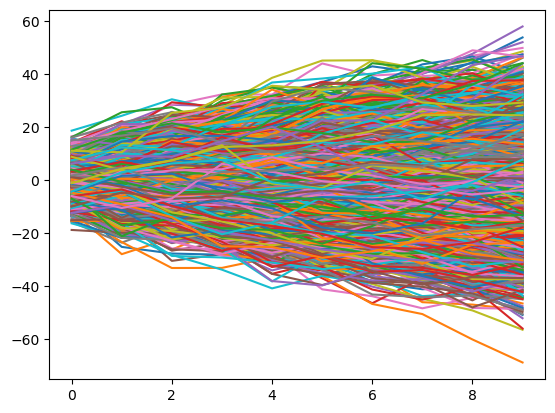

In [130]:
plt.plot(cds_returns_forecast_garch['PX1']['AAPL'])

In [147]:
def forecast_all_paths(cds_returns, returns_forecast):

    px_columns = [f'PX{i}' for i in range(1, 11)]
    tickers = cds_returns['Ticker'].unique()

    all_paths_forecast = {}

    for col in px_columns:
        all_paths_forecast[col] = {}

        for ticker in tickers:
            last_price = cds_returns[cds_returns['Ticker'] == ticker][col].dropna().iloc[-1]
            sim_cumulative_returns = returns_forecast[col][ticker]  # shape: (K, MC)

            # convert cum. returns to prices - * 10**4 because prices in bps 
            price_paths = last_price * np.exp(sim_cumulative_returns / 100)

            all_paths_forecast[col][ticker] = price_paths

    return all_paths_forecast

In [148]:
price_forecast_garch = forecast_all_paths(cds_returns, cds_returns_forecast_garch)

In [155]:
cds_prices_apple =  cds_data[cds_data['Ticker'] == 'AAPL']
cds_prices_apple = cds_prices_apple.drop(['Ticker', 'Company'], axis=1)
cds_prices_apple = cds_prices_apple / 100

In [156]:
cds_prices_apple

,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
Date,,,,,,,,,,
2015-01-01,0.083000,0.111000,0.129000,0.168000,0.236000,0.318000,0.366950,0.428000,0.476050,0.516000
2015-01-02,0.083000,0.111000,0.129000,0.168000,0.236000,0.318050,0.367050,0.428000,0.476050,0.516000
2015-01-05,0.095350,0.128000,0.148900,0.194150,0.272900,0.365200,0.418600,0.484550,0.535600,0.577700
2015-01-06,0.078200,0.104550,0.121450,0.158150,0.222250,0.301100,0.349050,0.409050,0.456700,0.496700
2015-01-07,0.078350,0.104750,0.121750,0.158600,0.223000,0.302200,0.350350,0.410650,0.458500,0.498600
...,...,...,...,...,...,...,...,...,...,...
2021-09-06,0.089743,0.113786,0.149022,0.197909,0.249750,0.301480,0.338160,0.361508,0.379590,0.394028
2021-09-07,0.090938,0.113503,0.149447,0.198661,0.250044,0.302151,0.339095,0.362367,0.380375,0.394716
2021-09-08,0.090012,0.112324,0.147874,0.196538,0.247329,0.298982,0.335697,0.358889,0.376874,0.391222


In [157]:
price_forecast_garch['PX1']['AAPL']

array([[-0.5617598 , -0.56139619, -0.56123048, ..., -0.56184895,
        -0.56168368, -0.56150625],
       [-0.56195436, -0.56127436, -0.56111228, ..., -0.56202211,
        -0.56199101, -0.56191454],
       [-0.5618854 , -0.56106566, -0.561431  , ..., -0.56160818,
        -0.56217003, -0.56210242],
       ...,
       [-0.56119858, -0.56142638, -0.56080772, ..., -0.56203326,
        -0.56312453, -0.56133944],
       [-0.56114412, -0.56150173, -0.56091822, ..., -0.56242699,
        -0.56314402, -0.56170769],
       [-0.56090267, -0.56156037, -0.56095181, ..., -0.56270315,
        -0.56312277, -0.56218742]])

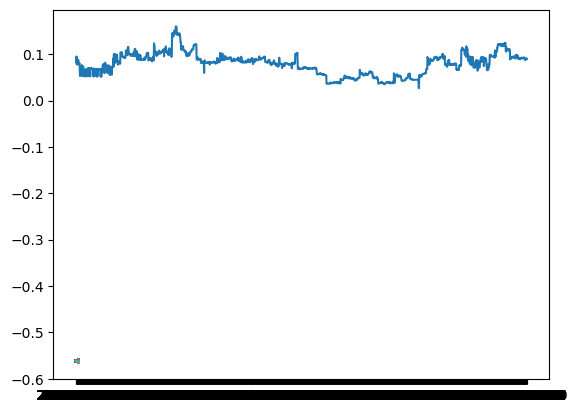

In [158]:
plt.plot(price_forecast_garch['PX1']['AAPL'])
plt.plot(cds_prices_apple['PX1'])